# Predicciones temporales con modelos de IA

Dentro de este cuaderno de Jupyter se estudiarán distintos modelos de IA para llevar a cabo predicciones sobre series temporales. Los distintos apartados que se presentarán en el cuaderno son:

 1. Carga de librerias, modelos y herramientas a utilizar
 2.  Análisis y preprocesamiento de datos
 3. Creación y estudio de predicciones con LSTM
 4. Creación y estudio de predicciones con Prophet
 5. Creación y estudio de predicciones con TimeGPT
 6.  Análisis de resultados y modelo a usar

## 1. Carga de librerias, modelos y herramientas

In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilsforecast.preprocessing import fill_gaps

Para este primer acercamiento se tomará como referencia los datos del sensor Suntracer localizado en el Edificio Centro de Investigaciones Tecnológicas de la Información y las Comunicaciones

In [432]:
# Load the data
data = pd.read_csv('data/wot-data-db.interactions-datas_suntracer_temperature.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
#Rename the column of data value to temperature
data.rename(columns = {'data.value':'temperature (Cº)'}, inplace = True)

df = data[['timestamp', 'temperature (Cº)']]


df.head(15)

,timestamp,temperature (Cº)
0,2023-03-03 09:30:00,22.7
1,2023-03-03 09:31:00,22.2
2,2023-03-03 09:32:00,21.8
3,2023-03-03 09:33:00,22.1
4,2023-03-03 09:34:00,22.6
5,2023-03-03 09:35:00,22.7
6,2023-03-03 09:36:00,23.3
7,2023-03-03 09:37:00,23.9
8,2023-03-03 09:39:00,24.2
9,2023-03-03 09:40:00,24.3


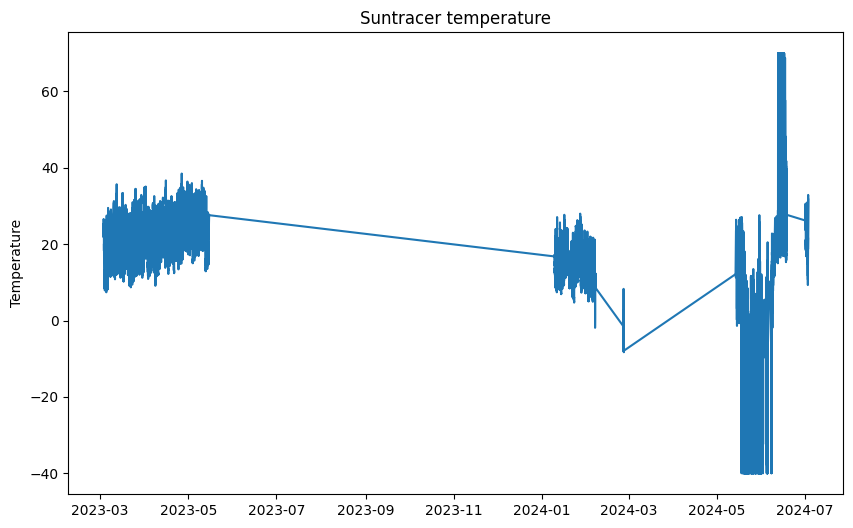

In [433]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(df['timestamp'], df['temperature (Cº)'])
plt.title('Suntracer temperature')
plt.ylabel('Temperature')
plt.show()

Los datos completos del Suntracer no son favorables a ser tratados directamente dentro del modelo debido a distintos problemas:
- Datos extremos y, probablemente, erróneos como temperaturas de -40º o 70º
- Ausencia de datos por largos periodos temporales, como lo son del 2023-05-16 al 2024-01-09

### Datos extremos

##### Temperaturas mínimas de -40º y máximas de 70º

In [434]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp,134665,2023-09-22 23:04:28.315598080,2023-03-03 09:30:00,2023-04-06 15:04:00,2023-05-10 02:02:00,2024-05-14 10:14:00,2024-07-03 09:18:00,NaN
temperature (Cº),134665.0,17.323239,-40.0,13.0,18.2,24.4,70.0,15.474028


### Ausencia de datos por largos periodos

In [435]:
# Dataframe auxiliar para mostrar datos faltantes
test_missing_data = df.copy()
test_missing_data.set_index('timestamp', inplace=True)

##### 16/5/2023 - 8/1/2024

In [436]:
missing_6_months = test_missing_data['2023-05-16':'2024-01-08']
missing_6_months.head()

,temperature (Cº)
timestamp,


##### 27/2/2024 - 13/5/2024

In [437]:
missing_3_months = test_missing_data['2024-02-27':'2024-05-13']
missing_3_months.head()

,temperature (Cº)
timestamp,


##### 19/6/2024 - 30/6/2024

In [438]:
# Check for data between 2024-06-18 and 2024-07-01 to prove the missing values and values are taken weirdly
missing_actual = test_missing_data['2024-06-19':'2024-06-30']
missing_actual.head()

,temperature (Cº)
timestamp,


Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023

In [439]:
reduced_df = df[(df['timestamp'] >= '2023-03-01') & (df['timestamp'] <= '2023-05-15')]
reduced_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp,72237,2023-04-09 05:01:04.047510272,2023-03-03 09:30:00,2023-03-22 16:05:00,2023-04-08 21:59:00,2023-04-27 05:29:00,2023-05-15 00:00:00,NaN
temperature (Cº),72237.0,21.258107,7.4,16.1,20.9,26.2,38.5,6.039438


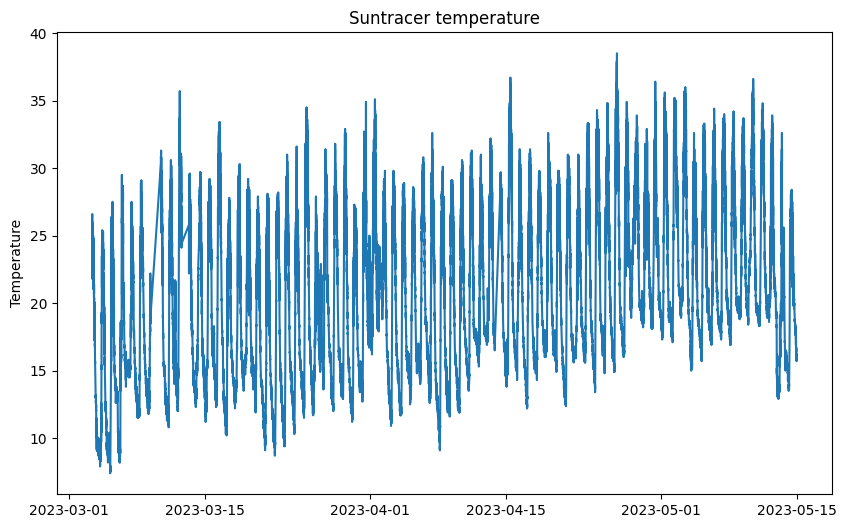

In [440]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(reduced_df['timestamp'], reduced_df['temperature (Cº)'])
plt.title('Suntracer temperature')
plt.ylabel('Temperature')
plt.show()

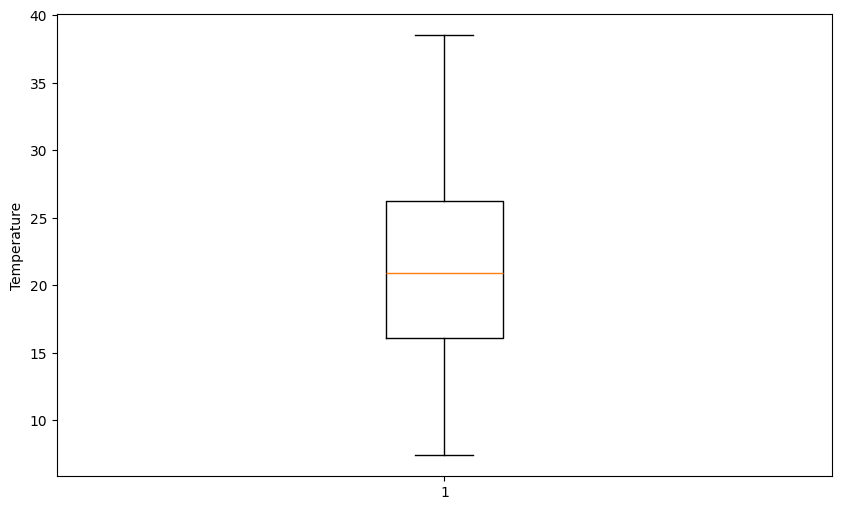

In [441]:
# Boxplot
plt.figure(figsize=(10,6))
plt.boxplot(reduced_df['temperature (Cº)'])
plt.ylabel('Temperature')
plt.show()


Tratamiento de los datos para eliminar los valores vacios

In [442]:
# Combinar los valores repetidos con el mismo timestamp con la media de los valores
print('Número de registros duplicados:', reduced_df.duplicated(subset='timestamp').sum())
reduced_df = reduced_df.groupby('timestamp').mean().reset_index()
print('Número de registros duplicados:', reduced_df.duplicated(subset='timestamp').sum())

reduced_df.describe().transpose()


Número de registros duplicados: 491
Número de registros duplicados: 0


,count,mean,min,25%,50%,75%,max,std
timestamp,71746,2023-04-09 05:08:38.975831296,2023-03-03 09:30:00,2023-03-22 16:08:15,2023-04-08 22:15:30,2023-04-27 05:35:45,2023-05-15 00:00:00,NaN
temperature (Cº),71746.0,21.251211,7.4,16.1,20.9,26.2,38.5,6.037587


In [443]:
reduced_df.head(10)

,timestamp,temperature (Cº)
0,2023-03-03 09:30:00,22.7
1,2023-03-03 09:31:00,22.2
2,2023-03-03 09:32:00,21.8
3,2023-03-03 09:33:00,22.1
4,2023-03-03 09:34:00,22.6
5,2023-03-03 09:35:00,22.7
6,2023-03-03 09:36:00,23.3
7,2023-03-03 09:37:00,23.9
8,2023-03-03 09:39:00,24.2
9,2023-03-03 09:40:00,24.3


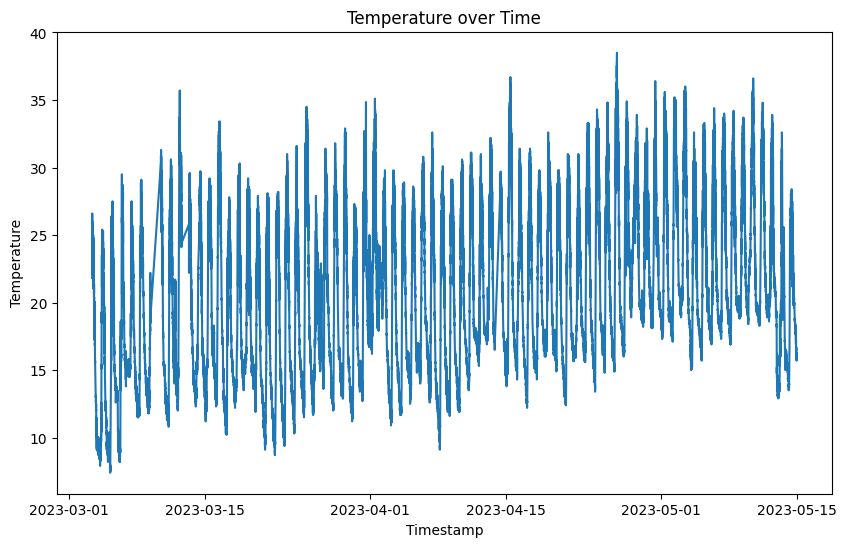

In [444]:
# Plot the data

plt.figure(figsize=(10,6))
plt.plot(reduced_df['timestamp'], reduced_df['temperature (Cº)'])
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

A partir de interpolación de datos añadimos los valores temporales que falten

In [445]:
# Quiero probar a ver que tal sale el fill gaps de eso
print("Original data: ", len(reduced_df), "rows")
gaps = reduced_df[['timestamp', 'temperature (Cº)']]
gaps.rename(columns={'timestamp': 'ds', 'temperature (Cº)': 'y'}, inplace=True)
gaps['ds'] = pd.to_datetime(gaps['ds'])
gaps['unique_id'] = 'suntracer_temperature'
gaps = gaps[['unique_id', 'ds', 'y']]
gaps.head()
completed_df = fill_gaps(gaps, freq='min')
print("Filled data: ", len(completed_df), "rows")



completed_df['y'] = completed_df['y'].interpolate(method='linear', limit_direction='both')
completed_df.describe().transpose()

Original data:  71746 rows
Filled data:  104551 rows


,count,mean,min,25%,50%,75%,max,std
ds,104551,2023-04-08 16:44:59.999999488,2023-03-03 09:30:00,2023-03-21 13:07:30,2023-04-08 16:45:00,2023-04-26 20:22:30,2023-05-15 00:00:00,NaN
y,104551.0,20.388311,7.4,15.75,19.5,25.2,38.5,5.832544


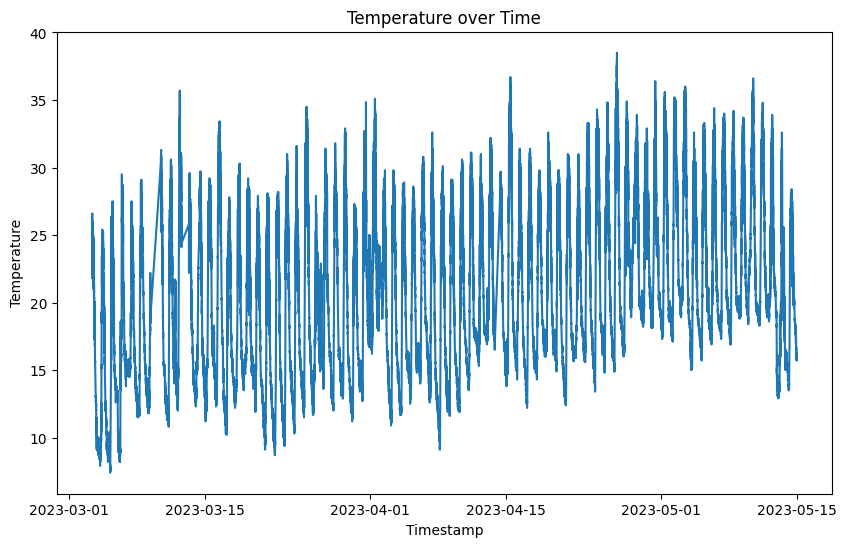

In [446]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(completed_df['ds'], completed_df['y'])
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

Testing with TimeGPT without treating the data

In [447]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key='nixtla-tok-0Xy1KrijueISj5UTfxyGuceKmM8KuLVGO1b92Xs1i3DZB0bUvmr2CjtSqjHn9UlTQokrx3Wl8C7dnOlE')
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

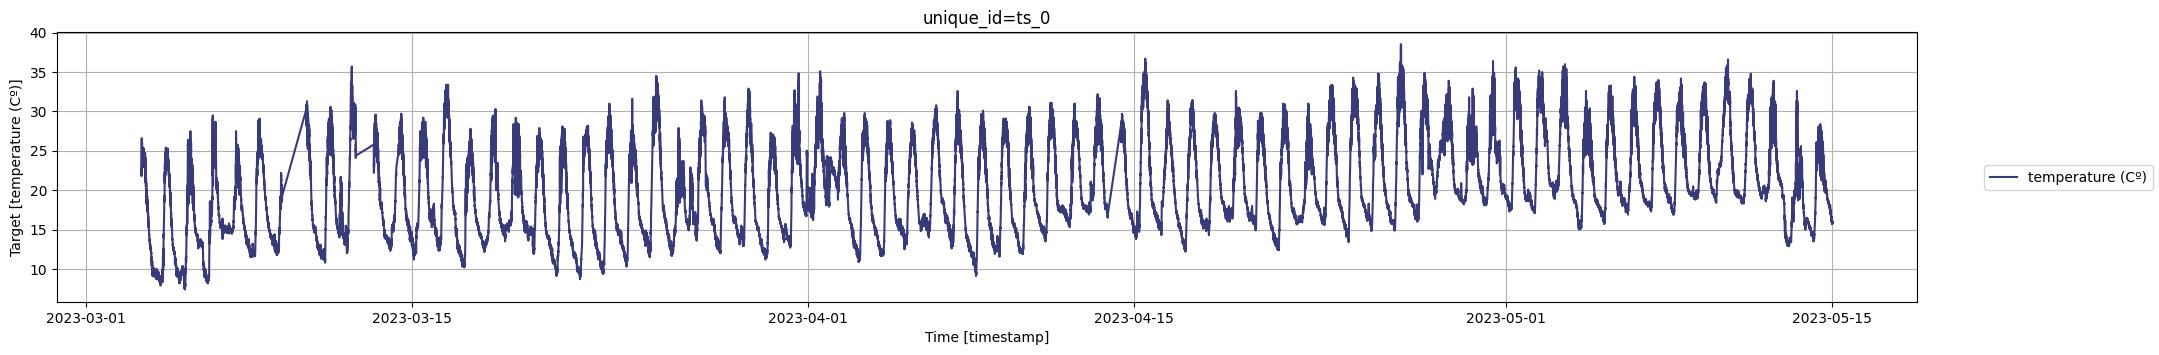

In [448]:
nixtla_client.plot(reduced_df,time_col='timestamp', target_col='temperature (Cº)')

In [449]:
#Separate to training and test data to predict the temperature
test = reduced_df.tail(15)
train = reduced_df.apply(lambda x: x.iloc[:-15]).reset_index(drop=True)

test_filled = completed_df.tail(15)
train_filled = completed_df.apply(lambda x: x.iloc[:-15]).reset_index(drop=True)

train.tail()

,timestamp,temperature (Cº)
71726,2023-05-14 23:30:00,16.0
71727,2023-05-14 23:32:00,16.1
71728,2023-05-14 23:33:00,16.2
71729,2023-05-14 23:36:00,16.0
71730,2023-05-14 23:37:00,15.8


In [450]:
test.head()

,timestamp,temperature (Cº)
71731,2023-05-14 23:40:00,15.9
71732,2023-05-14 23:42:00,15.8
71733,2023-05-14 23:44:00,16.0
71734,2023-05-14 23:46:00,15.9
71735,2023-05-14 23:47:00,15.8


In [451]:
# Forecast 10 minutes ahead
forecast = nixtla_client.forecast(
    df=train, 
    h=15, 
    freq='min',
    finetune_steps=10,
    finetune_loss='mae', 
    time_col='timestamp', 
    target_col='temperature (Cº)')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [429]:
forecast.head()


,timestamp,TimeGPT
0,2023-05-14 23:38:00,15.774347
1,2023-05-14 23:39:00,15.743005
2,2023-05-14 23:40:00,15.719766
3,2023-05-14 23:41:00,15.701108
4,2023-05-14 23:42:00,15.686300


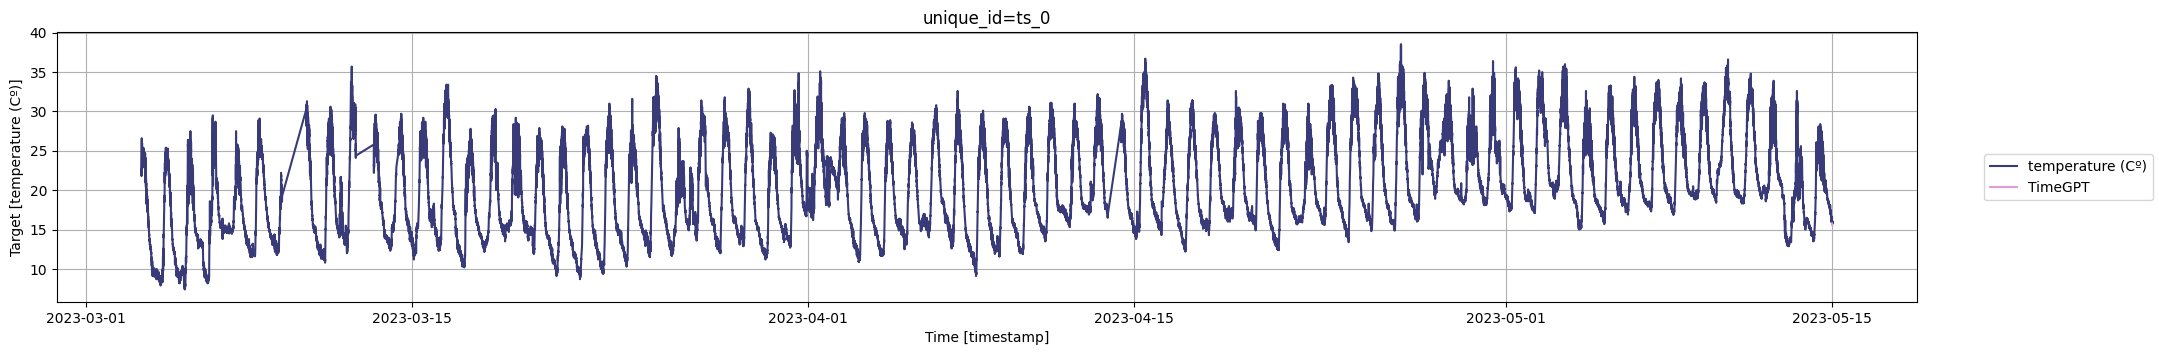

In [453]:
nixtla_client.plot(reduced_df, forecast, time_col='timestamp', target_col='temperature (Cº)')

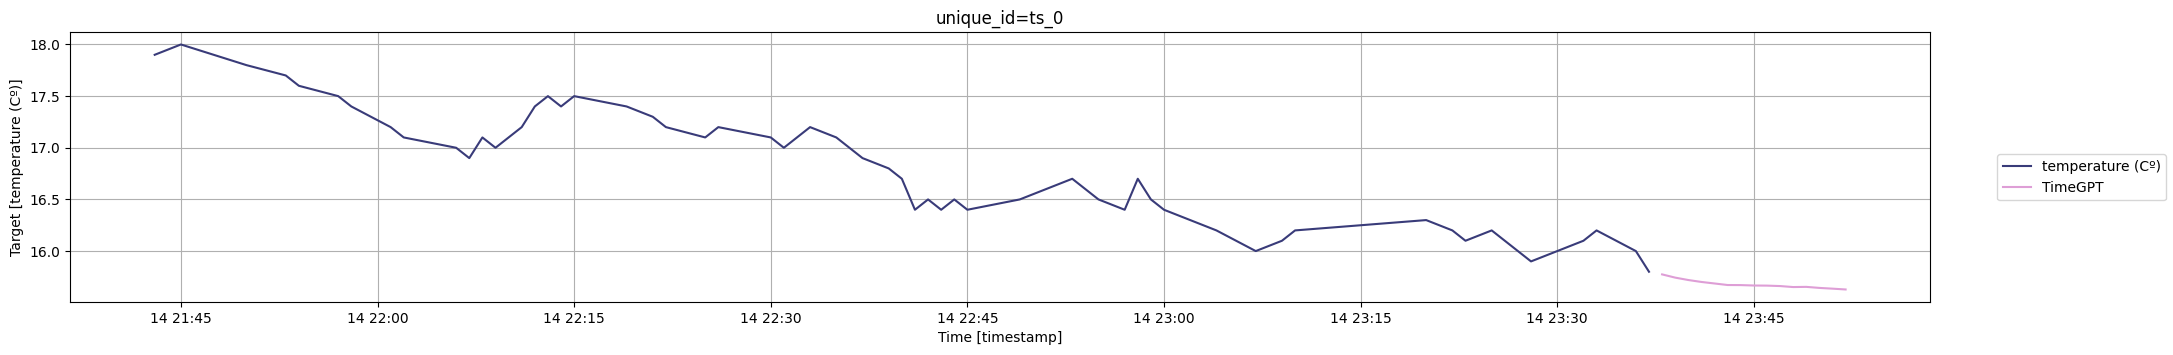

In [454]:
nixtla_client.plot(train, forecast, time_col='timestamp', target_col='temperature (Cº)', max_insample_length=60)

Detección de anomalias dentro de TimeGPT

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


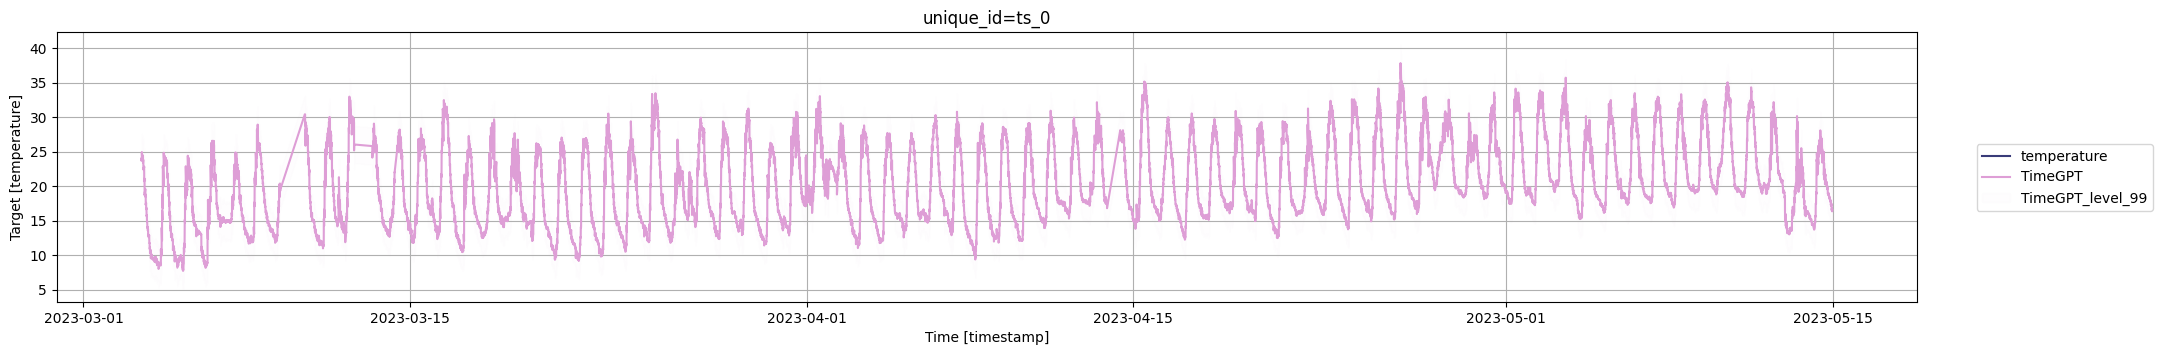

In [456]:
anomalies_df = nixtla_client.detect_anomalies(train, time_col='timestamp', target_col='temperature (Cº)', freq='min')
nixtla_client.plot(train, anomalies_df, time_col='timestamp', target_col='temperature')

In [457]:
forecast['timestamp'] = pd.to_datetime(forecast['timestamp'])


test = pd.merge(test, forecast, on='timestamp', how='left')

In [458]:
forecast_with_gaps = nixtla_client.forecast(
    df = train_filled,
    h = 1440,
    finetune_steps=10,
    finetune_loss='mae',
    time_col='ds',
    target_col='y',
    #model='timegpt-1-long-horizon'
    )
nixtla_client.plot(train_filled, forecast_with_gaps, time_col='ds', target_col='y')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Attempt 1 failed...
INFO:nixtla.nixtla_client:Attempt 2 failed...


In [ ]:
# Evaluate the model
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
from utilsforecast.losses import mse

In [ ]:
forecast_with_gaps['ds'] = pd.to_datetime(forecast_with_gaps['ds'])

results = completed_df.merge(forecast_with_gaps, on=['ds', 'unique_id'], how='left')
results.tail()

In [ ]:
evaluate(results, metrics=[mae])

,unique_id,metric,TimeGPT
0,suntracer_temperature,mae,2.18703
